<img src="./tec_logo.png" width="auto" height="200" />

# Examen: Manejo de técnicas de PLN para entender un corpus de datos

Marcos Dayan Mann

A01782876

## Importar librerías y descargar datasets para nltk

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from collections import Counter, defaultdict
import networkx as nx

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ngrams

import spacy

import gensim
from gensim import corpora
from gensim.models import Word2Vec, LdaModel, CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from transformers import BertTokenizer, BertModel
import torch

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

True

## Carga y Limpieza de Datos

Cargo el texto y elimino los encabezados y pies de página de Project Gutenberg para analizar solo el contenido de la novela.

In [133]:
def load_and_clean_text(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # esto es lo que delimita el libro origianl
    start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY ***"
    end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE GREAT GATSBY ***"
    
    start_idx = text.find(start_marker)
    end_idx = text.find(end_marker)
    
    if start_idx != -1:
        text = text[start_idx + len(start_marker):]
    if end_idx != -1:
        text = text[:end_idx]
        
    text = text.strip()
    return text

filename = 'the-great-gatsby-project-gutenberg.txt'
raw_text = load_and_clean_text(filename)
print(f"Longitud del texto cargado: {len(raw_text)} caracteres")
print(f"Primeros 500 caracteres:\n{raw_text[:500]}...")

Longitud del texto cargado: 271561 caracteres
Primeros 500 caracteres:
The Great Gatsby
                                  by
                          F. Scott Fitzgerald


                           Table of Contents

I
II
III
IV
V
VI
VII
VIII
IX


                              Once again
                                  to
                                 Zelda


  Then wear the gold hat, if that will move her;
  If you can bounce high, bounce for her too,
  Till she cry “Lover, gold-hatted, high-bouncing lover,
  I must have you!”

  Thomas Parke d’Invilliers

...


## 1. Genere una visualización utilizando la ley de Zipf para ver la calidad del corpus a analizar. Justifique la calidad del corpus en base al grafico presentado.

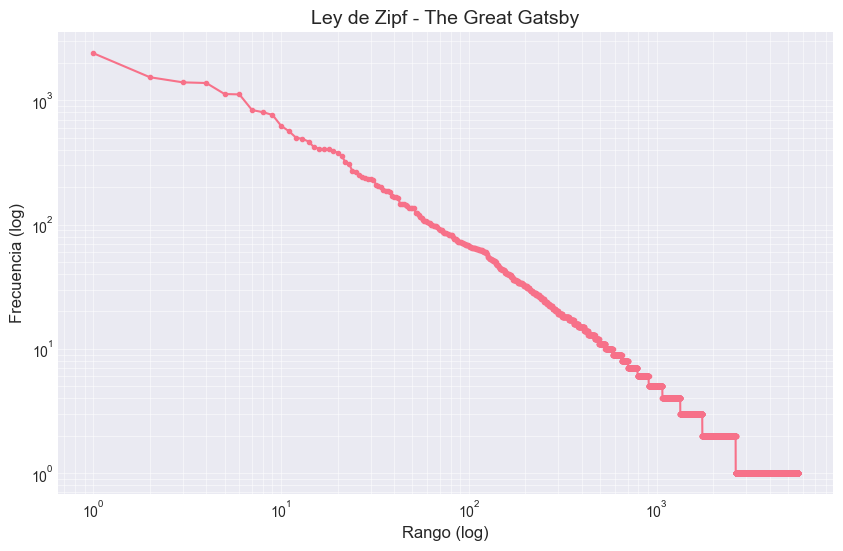

In [134]:
sentence_tokens = sent_tokenize(raw_text)
tokens = word_tokenize(raw_text)
# filtrar puntuación para la ley de Zipf 
words_only = [word.lower() for word in tokens if word.isalpha()]
word_counts = Counter(words_only)

# Datos para el gráfico
frequencies = sorted(word_counts.values(), reverse=True)
ranks = range(1, len(frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker=".")
plt.title("Ley de Zipf - The Great Gatsby", fontsize=14)
plt.xlabel("Rango (log)", fontsize=12)
plt.ylabel("Frecuencia (log)", fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

Análisis:

El gráfico muestra una línea descendente casi recta, que como vimos en clase, esto es característico de un corpus de lenguaje natural saludable que sigue la Ley de Zipf. Esto nos dice que hay unas pocas palabras muy frecuentes (como "the", "and", "of") y una larga cola de palabras poco frecuentes. Con esto, la ley de Zipf sugiere que el texto es representativo del lenguaje humano natural y tiene una riqueza léxica adecuada para realizar análisis de NLP más profundos.

## 2. Contar el número total de palabras en el corpus.

In [135]:
total_words = len(words_only)
print(f"2. Número total de palabras, solo palabras: {total_words}")

2. Número total de palabras, solo palabras: 48170


## 3. Contar la cantidad de palabras únicas en el texto.

In [136]:
unique_words_set = set(words_only)
unique_words_count = len(unique_words_set)
print(f"3. Cantidad de palabras únicas: {unique_words_count}")

3. Cantidad de palabras únicas: 5652


## 4. Contar el número de palabras que comienzan con letras mayúsculas.

In [137]:
original_words = [word for word in tokens if word.isalpha()]
capitalized_words = [word for word in original_words if word[0].isupper()]
count_capitalized = len(capitalized_words)
print(f"4. Número de palabras que comienzan con mayúsculas: {count_capitalized}")

4. Número de palabras que comienzan con mayúsculas: 6092


## 5. Contar el número de palabras que comienzan con letras minúsculas.

In [138]:
lowercase_start_words = [word for word in original_words if word[0].islower()]
count_lowercase = len(lowercase_start_words)
print(f"5. Número de palabras que comienzan con minúsculas: {count_lowercase}")

5. Número de palabras que comienzan con minúsculas: 42078


## 6. Contar la frecuencia de las palabras cerradas (stopwords) en el corpus.

In [139]:
stop_words = set(stopwords.words('english'))
stopwords_in_text = [word for word in words_only if word in stop_words]
stopwords_freq = Counter(stopwords_in_text)
total_stopwords = len(stopwords_in_text)

print(f"6. Frecuencia total de stopwords: {total_stopwords}")
print(f"   Porcentaje del texto que son stopwords: {(total_stopwords/total_words)*100:.2f}%")
print("   Top 10 stopwords más comunes:")
for word, freq in stopwords_freq.most_common(10):
    print(f"     - {word}: {freq}")

6. Frecuencia total de stopwords: 25873
   Porcentaje del texto que son stopwords: 53.71%
   Top 10 stopwords más comunes:
     - the: 2392
     - and: 1533
     - a: 1394
     - i: 1377
     - to: 1123
     - of: 1115
     - he: 835
     - in: 802
     - was: 763
     - that: 623


## 7. Identificar y contar las palabras más comunes en el texto.

In [140]:
meaningful_words = [word for word in words_only if word not in stop_words] # quito stop words
meaningful_counts = Counter(meaningful_words)

print("7. Las 20 palabras más comunes sin stopwords:")
for word, freq in meaningful_counts.most_common(20):
    print(f"   - {word}: {freq}")

7. Las 20 palabras más comunes sin stopwords:
   - gatsby: 252
   - said: 233
   - tom: 188
   - daisy: 183
   - one: 146
   - like: 119
   - came: 108
   - back: 107
   - little: 103
   - man: 98
   - house: 90
   - went: 90
   - know: 90
   - eyes: 86
   - got: 85
   - come: 83
   - old: 82
   - looked: 82
   - wilson: 77
   - time: 76


Algo importante a notar en análisis de texto en libros, es que las palabras más comunes tienden a ser nombres o cosas específicas de los mismos, así que si se quisiera usar libros para el entrenamiento de un modelo que analice sentimiento, o haga otro tipo de análisis, es importante quitar estas palabras para tener resultados que sean más precisos a la realidad.

## 8. Identificar y contar la frecuencia de nombres propios en el corpus.

In [141]:
#  POS tagging para identificar nombres propios (NNP y NNPS)
pos_tags = pos_tag(original_words)
proper_nouns = [word for word, tag in pos_tags if tag in ['NNP', 'NNPS']]
proper_noun_counts = Counter(proper_nouns)

print(f"8. Frecuencia total de nombres propios detectados: {len(proper_nouns)}")
print("   Top 15 nombres propios más frecuentes:")
for word, freq in proper_noun_counts.most_common(15):
    print(f"     - {word}: {freq}")

8. Frecuencia total de nombres propios detectados: 2598
   Top 15 nombres propios más frecuentes:
     - Gatsby: 250
     - Tom: 188
     - Daisy: 180
     - Wilson: 77
     - Jordan: 70
     - New: 43
     - A: 40
     - Baker: 39
     - Oh: 35
     - Miss: 34
     - West: 33
     - York: 28
     - Wolfshiem: 28
     - Egg: 27
     - Well: 26


## 9. Contar el número total de oraciones en el corpus.

In [142]:
sentences = sent_tokenize(raw_text)
total_sentences = len(sentences)
print(f"9. Número total de oraciones: {total_sentences}")

9. Número total de oraciones: 2445


## 10. Calcular la longitud promedio de las oraciones.

In [143]:
sentence_lengths = [len(word_tokenize(sent)) for sent in sentences]
avg_sentence_length = np.mean(sentence_lengths)

print(f"10. Longitud promedio de las oraciones: {avg_sentence_length:.2f} palabras")

10. Longitud promedio de las oraciones: 24.85 palabras


## 11. Contar cuántas veces aparecen cada uno de los signos de puntuación.

In [144]:
punctuation_counts = Counter(char for char in raw_text if char in string.punctuation)

print("11. Frecuencia de signos de puntuación:")
for char, freq in punctuation_counts.most_common():
    print(f"    '{char}' : {freq}")

11. Frecuencia de signos de puntuación:
    '.' : 3112
    ',' : 2975
    '-' : 2047
    '?' : 328
    '!' : 125
    ':' : 81
    ';' : 74
    '*' : 12
    '(' : 8
    ')' : 8
    '[' : 2
    ']' : 2
    '$' : 2


## 12. Encontrar las palabras más largas en el texto.

In [145]:
sorted_by_length = sorted(list(unique_words_set), key=len, reverse=True)

print("12. Las 10 palabras más largas:")
for word in sorted_by_length[:10]:
    print(f"    - {word} ({len(word)} letras)")

12. Las 10 palabras más largas:
    - impressionability (17 letras)
    - indistinguishably (17 letras)
    - enthusiastically (16 letras)
    - misunderstanding (16 letras)
    - resourcefulness (15 letras)
    - straightforward (15 letras)
    - accomplishments (15 letras)
    - authoritatively (15 letras)
    - extraordinarily (15 letras)
    - understandingly (15 letras)


## 13. Contar el número de oraciones interrogativas.

In [146]:
interrogative_sentences = [sent for sent in sentences if sent.strip().endswith('?')]
count_interrogative = len(interrogative_sentences)

print(f"13. Número de oraciones interrogativas: {count_interrogative}")
print(f"    Porcentaje del total de oraciones: {count_interrogative/total_sentences*100:.2f}%")

13. Número de oraciones interrogativas: 54
    Porcentaje del total de oraciones: 2.21%


Éste resultado se me hizo un poco raro ya que es bastante menor al # de "?" en todo el texto. Me metí a analizar manualmente el corpus del texto, y vi que hay muchas oraciones en donde hay una o pocas palabras con un signo de interrogación, por lo que no se le considera una sentence a ésto. es importante considerar éste detalle que luego se presenta mucho en teztos de novelas.

## 14. Identificar y extraer entidades como nombres de personas, lugares y organizaciones.

In [147]:
# Acá estoy usando un modelo de Spacy para reconocer entidades nombradas, aunque no vimos ningún ejemplo puntual de cómo usarlo en clase, me tomé la libertad de ver la librería referencuada en el PDF PLN1 e investigar un poco de ella
try:
    nlp = spacy.load("en_core_web_sm")
except:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

nlp.max_length = len(raw_text) + 100
doc = nlp(raw_text)

entities = defaultdict(list)
for ent in doc.ents:
    if ent.label_ in ['PERSON', 'GPE', 'ORG']:
        entities[ent.label_].append(ent.text)

print("14. Entidades extraídas (Top 5 por categoría):")
for label, ents in entities.items():
    print(f"   Categoría: {label}")
    print(f"     Top 5: {Counter(ents).most_common(5)}")
    print(f"     Total únicos: {len(set(ents))}")

14. Entidades extraídas (Top 5 por categoría):
   Categoría: GPE
     Top 5: [('Jordan', 35), ('New York', 32), ('Michaelis', 22), ('Chicago', 20), ('West Egg', 14)]
     Total únicos: 84
   Categoría: PERSON
     Top 5: [('Gatsby', 243), ('Daisy', 165), ('Tom', 159), ('Wilson', 37), ('Baker', 28)]
     Total únicos: 162
   Categoría: ORG
     Top 5: [('Wilson', 28), ('Oxford', 11), ('Wolfshiem', 7), ('Nick', 5), ('McKee', 4)]
     Total únicos: 90


## 15. Encontrar y extraer todas las citas directas (entre comillas) en el corpus.

In [148]:
# Usamos regex para capturar texto entre comillas dobles (incluyendo las tipográficas)
quotes = re.findall(r'[“"](.*?)[”"]', raw_text)
print(f"15. Número total de citas directas encontradas: {len(quotes)}")
print("    Ejemplos de citas:")
for quote in quotes[:5]:
    print(f"    - \"{quote}\"")

15. Número total de citas directas encontradas: 1056
    Ejemplos de citas:
    - "Whenever you feel like criticizing anyone,"
    - "creative temperament"
    - "Why—ye-es,"
    - "How do you get to West Egg village?"
    - "well-rounded man."


## 16. Detectar y extraer preguntas en el texto.

Asumo que en todo lugar en donde haya un "?" es usado para una pregunta, e itero en los tokens hatsa encontrar un delimitador de oraciones para tener toda la oración de la pregunta.

In [149]:
questions = []

for i, word in enumerate(tokens):
    if "?" in word:
        full_question = ""
        it = i-1
        while "." not in tokens[it] and "?" not in tokens[it] and it >= 0:
            full_question = tokens[it] + " " + full_question
            it -= 1
        
        full_question = full_question.replace('\"', "").strip()
        full_question = full_question.lstrip("“").lstrip("”")

        full_question = full_question + word
        questions.append(full_question)

print(f"16. Preguntas extraídas ({len(questions)} total). Primeras 5:")
for i, question in enumerate(questions[:5]):
    # Limpiamos saltos de línea para mejor visualización
    clean_q = question.replace('\n', ' ').strip()
    print(f"    {i+1}. {clean_q}")

16. Preguntas extraídas (328 total). Primeras 5:
    1. How do you get to West Egg village?
    2. Do they miss me?
    3. Haven ’ t you ever seen her?
    4. What you doing , Nick?
    5. “ Who with?


## 17. Identificar palabras que tienen más de un significado.

In [150]:
# Uso WordNet para encontrar palabras con múltiples significados
polysemous_words = []
unique_meaningful_words = set(meaningful_words)

for word in list(unique_meaningful_words):
    synsets = wordnet.synsets(word)
    if len(synsets) > 1:
        polysemous_words.append((word, len(synsets)))

polysemous_words.sort(key=lambda x: x[1], reverse=True)

print("17. Palabras con mayor cantidad de significados:")
for word, count in polysemous_words[:10]:
    print(f"    - '{word}': {count} significados")

17. Palabras con mayor cantidad de significados:
    - 'break': 75 significados
    - 'broken': 72 significados
    - 'cut': 70 significados
    - 'broke': 60 significados
    - 'breaking': 60 significados
    - 'runs': 57 significados
    - 'run': 57 significados
    - 'cutting': 54 significados
    - 'running': 52 significados
    - 'play': 52 significados


## 18. Encontrar los bigramas, trigramas y cuatrigramas más relevantes en el texto.

In [151]:
def get_ngrams(tokens, n):
    n_grams = ngrams(tokens, n)
    return Counter(n_grams)

# tokens limpios para los n-gramas, quitando stop words
clean_tokens = [word for word in words_only if word not in stop_words]

bigrams = get_ngrams(clean_tokens, 2)
trigrams = get_ngrams(clean_tokens, 3)
fourgrams = get_ngrams(clean_tokens, 4)

print("18. N-gramas más frecuentes:")
print("   Bigramas:")
for bg, freq in bigrams.most_common(5):
    print(f"     {bg}: {freq}")
print("\n   Trigramas:")
for tg, freq in trigrams.most_common(5):
    print(f"     {tg}: {freq}")
print("\n   Cuatrigramas:")
for fg, freq in fourgrams.most_common(5):
    print(f"     {fg}: {freq}")

18. N-gramas más frecuentes:
   Bigramas:
     ('old', 'sport'): 32
     ('miss', 'baker'): 27
     ('new', 'york'): 27
     ('said', 'tom'): 24
     ('west', 'egg'): 23

   Trigramas:
     ('old', 'sport', 'said'): 6
     ('west', 'egg', 'village'): 5
     ('eyes', 'doctor', 'eckleburg'): 4
     ('look', 'old', 'sport'): 4
     ('two', 'young', 'women'): 3

   Cuatrigramas:
     ('always', 'watch', 'longest', 'day'): 2
     ('watch', 'longest', 'day', 'year'): 2
     ('longest', 'day', 'year', 'miss'): 2
     ('things', 'went', 'bad', 'worse'): 2
     ('came', 'gatsby', 'house', 'summer'): 2


## 19. Identificar cuáles son los temas/tópicos más recurrentes en el texto.

In [152]:
# chunks para tener más contexto que solo en por oraciones
chunks = []
current_chunk = []
for sent in sentences:
    current_chunk.append(sent)
    if len(current_chunk) >= 8:
        chunks.append(" ".join(current_chunk))
        current_chunk = []
if current_chunk:
    chunks.append(" ".join(current_chunk))

lda_tokens = [[word for word in word_tokenize(chunk.lower()) if word.isalpha() and word not in stop_words] for chunk in chunks]
dictionary = corpora.Dictionary(lda_tokens)
corpus = [dictionary.doc2bow(text) for text in lda_tokens]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

print("19. Tópicos identificados:")
for i, topic in lda_model.print_topics(-1):
    print(f"    Tópico {i}: {topic}")

19. Tópicos identificados:
    Tópico 0: 0.009*"said" + 0.009*"gatsby" + 0.007*"daisy" + 0.006*"tom" + 0.005*"know" + 0.004*"one" + 0.004*"wilson" + 0.004*"going" + 0.004*"looked" + 0.004*"two"
    Tópico 1: 0.008*"gatsby" + 0.007*"said" + 0.005*"daisy" + 0.004*"man" + 0.004*"one" + 0.004*"little" + 0.004*"know" + 0.003*"old" + 0.003*"new" + 0.003*"looked"
    Tópico 2: 0.005*"gatsby" + 0.005*"jordan" + 0.004*"came" + 0.004*"went" + 0.003*"little" + 0.003*"like" + 0.003*"people" + 0.003*"oxford" + 0.003*"one" + 0.003*"way"
    Tópico 3: 0.012*"tom" + 0.011*"said" + 0.011*"gatsby" + 0.008*"daisy" + 0.006*"one" + 0.006*"like" + 0.005*"wilson" + 0.005*"got" + 0.005*"back" + 0.005*"came"
    Tópico 4: 0.010*"gatsby" + 0.008*"said" + 0.007*"daisy" + 0.006*"one" + 0.005*"tom" + 0.005*"house" + 0.005*"get" + 0.005*"came" + 0.004*"eyes" + 0.004*"man"


El modelo LDA ha identificado varios temas recurrentes involucrando a los personajes del libro. De lo que veo, los tópicos más relevantes del libro son sonversaciones entre los personajes principales de diferentes temas relacionados a la historia del libro

## 20. Construir una representación de tipo Bag of Words y TF-IDF  y comparar cuales son las palabras mas relevantes para ambas sin tomar en cuenta las palabras cerradas.

Uso los chunks para construir cada uno de los vectores porque las sentences pueden estar un poco cortas para tener un vocabulario representativo en cada vector

In [153]:
# BoW
count_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = count_vectorizer.fit_transform(chunks)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(chunks)

print("20. Comparación BoW vs TF-IDF:")
print(f"    Dimensiones BoW: {bow_matrix.shape}")
print(f"    Dimensiones TF-IDF: {tfidf_matrix.shape}")
print("    (Filas = Documentos/Chunks, Columnas = Vocabulario)")

# Mostramos las palabras más importantes para el primer chunk según TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
first_doc_vector = tfidf_matrix[0]
df_tfidf = pd.DataFrame(first_doc_vector.T.todense(), index=feature_names, columns=["tfidf"])
print("\n    Palabras clave (TF-IDF) del primer fragmento:")
print(df_tfidf.sort_values(by="tfidf", ascending=False).head(5))

20. Comparación BoW vs TF-IDF:
    Dimensiones BoW: (306, 5573)
    Dimensiones TF-IDF: (306, 5573)
    (Filas = Documentos/Chunks, Columnas = Vocabulario)

    Palabras clave (TF-IDF) del primer fragmento:
               tfidf
lover       0.181525
judgements  0.181525
bounce      0.181525
snobbishly  0.181525
intimate    0.153958


## 21. Entrenar un modelo de embeddings y analizar qué palabras presentan mayor similitud semántica con el término clave que ustedes consideren del corpus.


In [154]:
# Entrenamos Word2Vec con nuestras oraciones tokenizadas
w2v_sentences = [word_tokenize(sent.lower()) for sent in sentences]
w2v_model = Word2Vec(sentences=w2v_sentences, vector_size=100, window=5, min_count=2, workers=4)

print("21. Análisis de similitud con Word2Vec:")
target_word = "gatsby" # porque es la palabra más común, sin contar stop words

similar_words = w2v_model.wv.most_similar(target_word, topn=5)
print(f"    Palabras más similares a '{target_word}':")
for word, score in similar_words:
    print(f"      - {word}: {score:.4f}")

21. Análisis de similitud con Word2Vec:
    Palabras más similares a 'gatsby':
      - all: 0.9997
      - but: 0.9997
      - like: 0.9997
      - daisy: 0.9996
      - so: 0.9996


## 22. Generar embeddings contextuales (BERT, por ejemplo) para varias oraciones del corpus y analizar cómo cambia el vector de una misma palabra cuando aparece en contextos diferentes.

In [155]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    all_embeddings = outputs.last_hidden_state[0]
    
    input_ids = inputs['input_ids'][0] 
    word_ids = tokenizer.encode(word, add_special_tokens=False)
    
    # Esto es necesario porque una palabra puede ser varios tokens en BERT
    for i in range(len(input_ids) - len(word_ids) + 1):
        if input_ids[i:i+len(word_ids)].tolist() == word_ids:
            word_embedding = all_embeddings[i:i+len(word_ids), :].mean(dim=0)
            return word_embedding.detach().numpy()
            
    return None

sentence1 = "I should change the light"
sentence2 = "She gave a light laugh."
sentence3 = "I wouldn’t think of changing the light"

embedding1 = get_bert_embedding(sentence1, "light")
embedding2 = get_bert_embedding(sentence2, "light")
embedding3 = get_bert_embedding(sentence3, "light")


def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

sim1 = cosine_similarity(embedding1, embedding2)
sim2 = cosine_similarity(embedding1, embedding3)

print(f"22. Similitud de coseno de 'light' en dos contextos diferentes: {sim1:.4f}")
print(f"    Contexto 1: {sentence1}")
print(f"    Contexto 2: {sentence2}")

print(f"    Similitud de coseno de 'light' en dos contextos iguales: {sim2:.4f}")
print(f"    Contexto 1: {sentence1}")
print(f"    Contexto 2: {sentence3}")

22. Similitud de coseno de 'light' en dos contextos diferentes: 0.2852
    Contexto 1: I should change the light
    Contexto 2: She gave a light laugh.
    Similitud de coseno de 'light' en dos contextos iguales: 0.9186
    Contexto 1: I should change the light
    Contexto 2: I wouldn’t think of changing the light


COmo se puede ver, cuando una palabra se usa en dos contextos diferentes, la similitud de coseno es menor que cuando se usa en el mismo contexto.

## 23. Comparar la capacidad de Bag of Words, TF-IDF y embeddings para capturar el significado semántico del texto, utilizando ejemplos del corpus.

En ésta sección, considero que no se puede hacer una comparación técnica entre los tres métodos para capturar el significado semántico del texto, ya que tanto BoW como TF-IDF no capturan relaciones semánticas profundas. EN el caso de BoW, solo cuenta la frecuencia de las palabras, con ésto es muy difícil entender el contexto y la semántica. Si tuvieramos palabras como "great" y "good", estas serían consideradas como totalmente diferentes, al igual que otras dos, cuando en realidad con BERT estas palabras estarían cerca, tendrían una similaridad del coseno alta. Pasa muy similar con TF-IDF. Éste tokenizer lo que tiene de ventaja, es que balancea y penaliza las palabras más comunes en el texto, rduciendo el ruido de ellas, pero ni hace nada para capturar la semántica. Por lo tanto, BERT es el mejor método para capturar el significado semántico del texto, porque vimos que captura las palabras en un espacio vectreoial, por lo que al comparar dos palabras, será más fácil idnetificar si se trata del mismo contexto a pesar de que sea la misma palabra, en base a cómo se representó vectroialmente el contexto alrededor de la palabra.


## 24. Evaluar cuál representación de las vistas en clase permite un mejor desempeño en una tarea sencilla de clasificación, como identificar oraciones interrogativas.


In [156]:
# Preparamos datos
labels = [1 if sent.strip().endswith('?') else 0 for sent in sentences]
X_train_text, X_test_text, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# 1. BoW
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train_text)
X_test_bow = vectorizer_bow.transform(X_test_text)

clf_bow = LogisticRegression()
clf_bow.fit(X_train_bow, y_train)
score_bow = clf_bow.score(X_test_bow, y_test)

# 2. TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_text)
X_test_tfidf = vectorizer_tfidf.transform(X_test_text)

clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)
score_tfidf = clf_tfidf.score(X_test_tfidf, y_test)

print("24. Resultados de Clasificación (Accuracy):")
print(f"    BoW Accuracy: {score_bow:.4f}")
print(f"    TF-IDF Accuracy: {score_tfidf:.4f}")


24. Resultados de Clasificación (Accuracy):
    BoW Accuracy: 0.9775
    TF-IDF Accuracy: 0.9816


En éste caso en donde tenemos algo tan trivial como detectar si es una oración interrogativa o no, no es muy relevante el contexto de las otras palabras, por lo que el vectroizador no influyó mucho, siento que el modelo detectó lo mismo enfocandose en la feature del ?, que es lo puncio representativo para este caso. 

## 25. Visualizar en un grafo de coocurrencia los puntos donde cambia los temas a lo largo del texto.

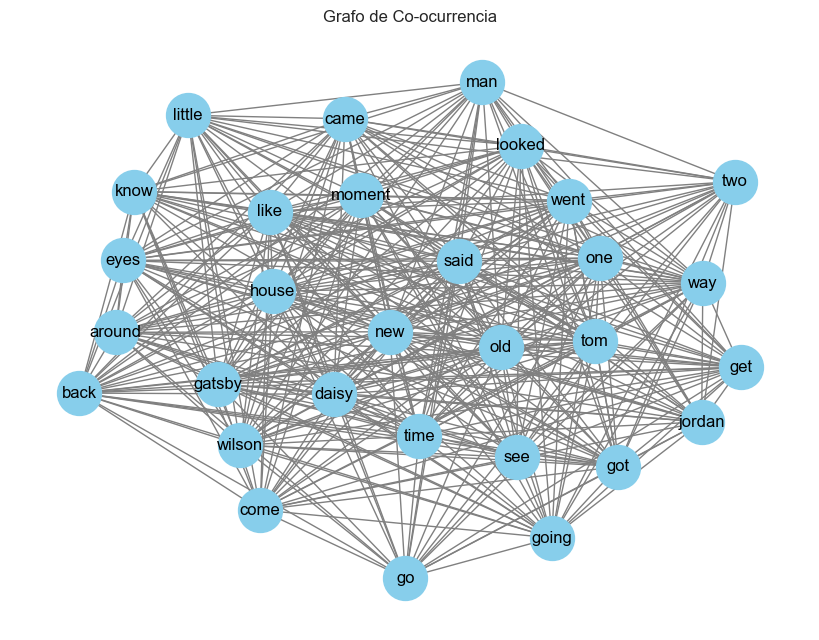

In [157]:
top_words = [word for word, freq in meaningful_counts.most_common(30)]

G = nx.Graph()

for sent in sentences:
    tokens = [word for word in word_tokenize(sent.lower()) if word in top_words]
    
    for token in tokens:
        G.add_node(token)
    
    for i, token in enumerate(tokens):
        if i < len(tokens) - 1:
            w1, w2 = token, tokens[i + 1]
            if w1 != w2 and not G.has_edge(w1, w2): # ésta parte la añadí porque habían muchas veces en donde ya existía esa relación de palabras antes, o habían palabras con una arista haciua el mismo nodo
                G.add_edge(w1, w2, weight=1)

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray')
plt.title("Grafo de Co-ocurrencia")
plt.axis('off')
plt.show()

En grandes textos, es un poco difícil de entender este tipo de diagramas, yo creo que sirve más como para ejemplos como el de clase, con un enunciado, o incluso con un texto pequeño, pero no de esta forma

## 26. Aplicar las metricas de centralidad vistas en clase para determinar topicos relevantes sobre el grafo del punto previo.
- Degree
- Closeness
- Betweenness

In [158]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# solo pongo 10 porque sino sería una lista interminable
print("26. Métricas de Centralidad:")
print("   Degree Centrality:")
for node, val in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"     - {node}: {val:.4f}")

print("\n   Closeness Centrality:")
for node, val in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"     - {node}: {val:.4f}")

print("\n   Betweenness Centrality:")
for node, val in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"     - {node}: {val:.4f}")

26. Métricas de Centralidad:
   Degree Centrality:
     - said: 1.0000
     - gatsby: 0.9655
     - one: 0.9655
     - went: 0.9655
     - tom: 0.9655
     - daisy: 0.9655
     - like: 0.9310
     - way: 0.9310
     - new: 0.9310
     - came: 0.8966

   Closeness Centrality:
     - said: 1.0000
     - gatsby: 0.9667
     - one: 0.9667
     - went: 0.9667
     - tom: 0.9667
     - daisy: 0.9667
     - like: 0.9355
     - way: 0.9355
     - new: 0.9355
     - came: 0.9062

   Betweenness Centrality:
     - said: 0.0063
     - tom: 0.0060
     - gatsby: 0.0058
     - one: 0.0058
     - way: 0.0056
     - daisy: 0.0055
     - like: 0.0052
     - went: 0.0052
     - new: 0.0052
     - house: 0.0050


## 27. Proponer alguna tecnica de machine learning para agrupar texto (k-means, hearchical clustering, etc). hablando del proposito de esto para entender un corpus de datos.


Para ésto, propondré usar el algoritmo de K-Means sobre vectores TF-IDF para agrupar los chunks del texto, de ésta forma podremos ver si hay secciones del libro que se agrupan temáticamente.

In [159]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

print(f"27. Clustering con K-Means (k={num_clusters}):")

# Ver palabras clave por cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"   Cluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"     Palabras clave: {', '.join(top_terms)}")
    
sil_score = silhouette_score(tfidf_matrix, kmeans.labels_) # nos dice qué tan separados están los clusters
print(f"\n   Silhouette Score: {sil_score:.4f}") 

27. Clustering con K-Means (k=10):
   Cluster 0:
     Palabras clave: series, mixed, world, man, oxford, grass, gatsby, like, 1919, come
   Cluster 1:
     Palabras clave: mrs, mckee, like, tom, think, wilson, white, said, myrtle, daisy
   Cluster 2:
     Palabras clave: wilson, michaelis, car, tom, garage, george, office, man, stop, heard
   Cluster 3:
     Palabras clave: gatsby, tom, know, didn, daisy, said, going, want, ll, years
   Cluster 4:
     Palabras clave: dog, things, little, people, ve, got, tom, looked, eyes, looking
   Cluster 5:
     Palabras clave: gatsby, jordan, sloane, went, butler, brought, tom, party, named, biloxi
   Cluster 6:
     Palabras clave: gatsby, man, mr, wolfshiem, said, time, war, went, just, college
   Cluster 7:
     Palabras clave: car, daisy, house, thought, don, said, gatsby, just, away, night
   Cluster 8:
     Palabras clave: miss, baker, said, daisy, mr, don, ve, heard, tom, table
   Cluster 9:
     Palabras clave: house, daisy, gatsby, year,